In [100]:
from modules.cosmology import cosmo_fn
from astropy import units as u
from astropy.coordinates import SkyCoord
from modules.data_preprocess import preprocess_planck_data as ppd
from simulate import cluster_templates as cltemp
from flat_sky_codes import flat_sky_analysis as fsa
from settings import mmf_settings as mmfset
from filters import modular_multi_matched_filter as mmf
from masking import gen_masks as gm
from flat_sky_codes import tangent_plane_analysis as tpa
from modules.simulate.spatial_template import sim_cluster as sc
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [ ]:
mmfset.init()
tmplt=cltemp.cluster_spectro_spatial_templates(T_min=0.,T_max=1.,T_step=1.,theta500_min=2.,theta500_max=4.,theta_step=1.)
tmplt.setup_templates()
emask=gm.return_edge_apodized_mask()
op=mmf.multi_matched_filter(tmplt.sp_ft_bank,tmplt.sz_spec_bank,tmplt.chfiltr,tmplt.fn_yerr_norm)

In [77]:
dtype=["T500","T500_err","z","Mg500","Mg500_err","M500","M500_err","RA","DEC","R500","YSZ_500","YSZ_500_err","YX_500","YX_500_err"]
data=loadtxt("../data/datain/table4_A_and_A_536_A11_2011.txt")
xsz_cat={}
for idx,d in enumerate(dtype):
    xsz_cat[d]=data[:,idx]
    
# Estimate the galactic latitude and longitude from RA and DEC
RA=xsz_cat["RA"] ; DEC=xsz_cat["DEC"]
c = SkyCoord(RA, DEC, frame='icrs', unit='deg')
xsz_cat["GLON"]=c.galactic.l.degree
xsz_cat["GLAT"]=c.galactic.b.degree

# Get the angular size for clusters
xsz_cat["theta500"]=(xsz_cat["R500"]/(cosmo_fn.dA(xsz_cat["z"])*1000))*180.*60./np.pi

In [167]:
cidx=2
glon=xsz_cat["GLON"][cidx]
glat=xsz_cat["GLAT"][cidx]
R500=xsz_cat["R500"][cidx]
T500=xsz_cat["T500"][cidx]
theta500=xsz_cat["theta500"][cidx]
redshift=xsz_cat["z"][cidx]
data,ps_mask,ext_ps_mask=ppd.return_tangent_planes(glon,glat)
projop=tpa.tangent_plane_setup(mmfset.nside,mmfset.xsize,glat,glon,rescale=1.)

In [168]:
template=tmplt.gen_template(thetac=theta500)
template_ft=fsa.map2alm(np.fft.fftshift(template),mmfset.reso)

temp=tmplt.sz_op.bp_fn_sz_2d_T(0,mmfset.channels)[:,0]
szspec={}
for i,ch in enumerate(mmfset.channels):
    szspec[ch]=temp[i]
    
temp=tmplt.sz_op.bp_fn_sz_2d_T(T500,mmfset.channels)[:,0]
szspecT={}
for i,ch in enumerate(mmfset.channels):
    szspecT[ch]=temp[i]

In [169]:
op.get_data_ft(data*ps_mask*emask,smwin=5)
fdata,err=op.evaluate_mmf(template_ft,szspec)
ix,iy=projop.ang2ij(glon,glat)
yc=fdata[ix,iy]
cluster=sc.gen_field_cluster_template(ix,iy,theta500,npix=mmfset.npix,pixel_size=mmfset.reso,y0=yc,cutoff=5.)
Y500=np.sum(cluster)*mmfset.reso*mmfset.reso
Y500_err=err*np.sum(cluster/yc)*mmfset.reso*mmfset.reso
print Y500*((cosmo_fn.dA(redshift)*(np.pi/180./60.))**2.)*1e4
print Y500_err*((cosmo_fn.dA(redshift)*(np.pi/180./60.))**2.)*1e4

op.get_data_ft(data*ps_mask*emask,smwin=5)
fdata,err=op.evaluate_mmf(template_ft,szspecT)
ix,iy=projop.ang2ij(glon,glat)
yc=fdata[ix,iy]
cluster=sc.gen_field_cluster_template(ix,iy,theta500,npix=mmfset.npix,pixel_size=mmfset.reso,y0=yc,cutoff=5.)
Y500=np.sum(cluster)*mmfset.reso*mmfset.reso
Y500_err=err*np.sum(cluster/yc)*mmfset.reso*mmfset.reso
print Y500*((cosmo_fn.dA(redshift)*(np.pi/180./60.))**2.)*1e4
print Y500_err*((cosmo_fn.dA(redshift)*(np.pi/180./60.))**2.)*1e4

1.1658536842
0.184831726779
1.25466969967
0.199768584888


<IPython.core.display.Javascript object>


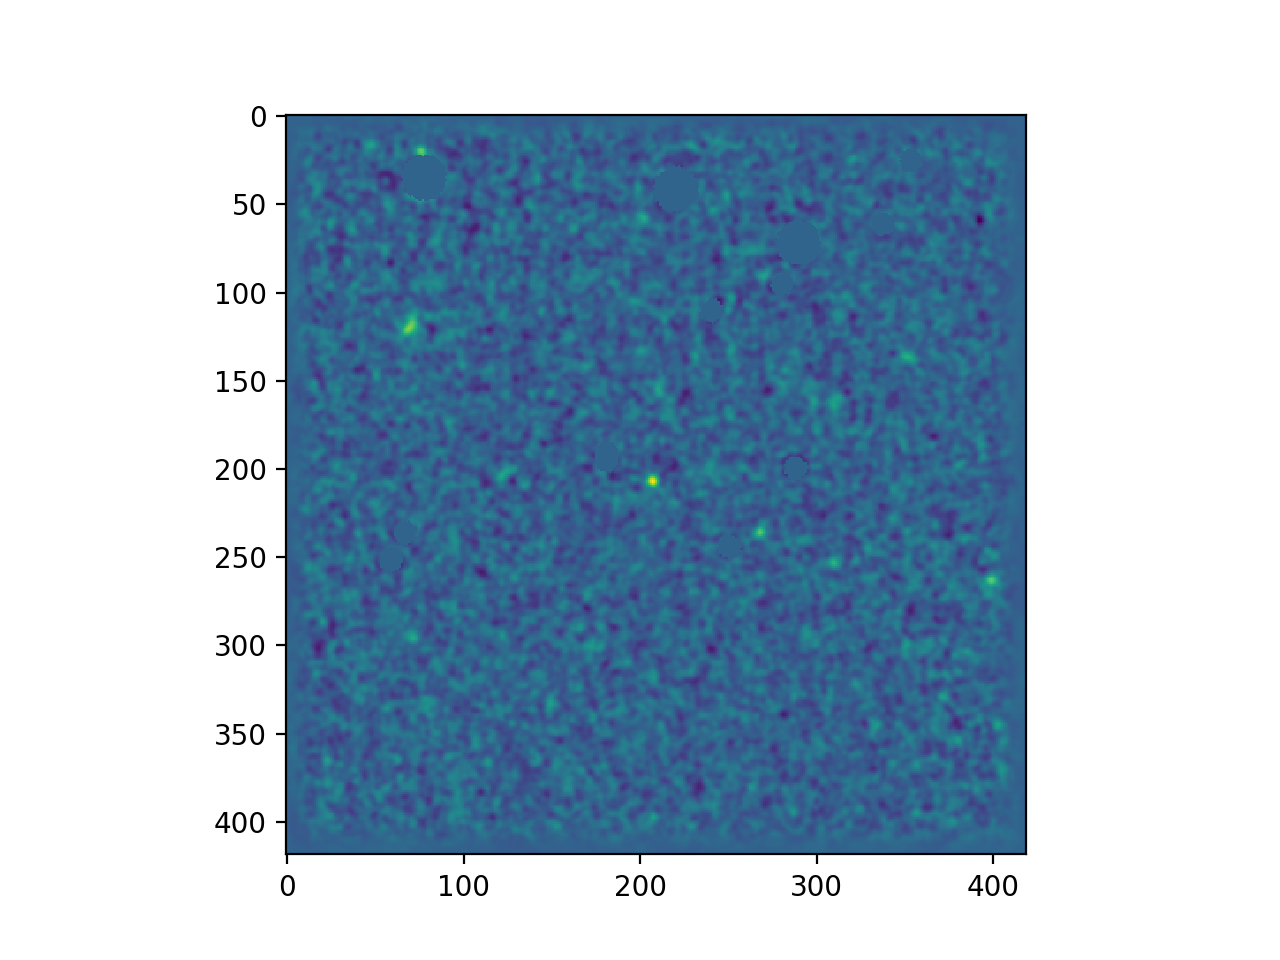

<IPython.core.display.Javascript object>


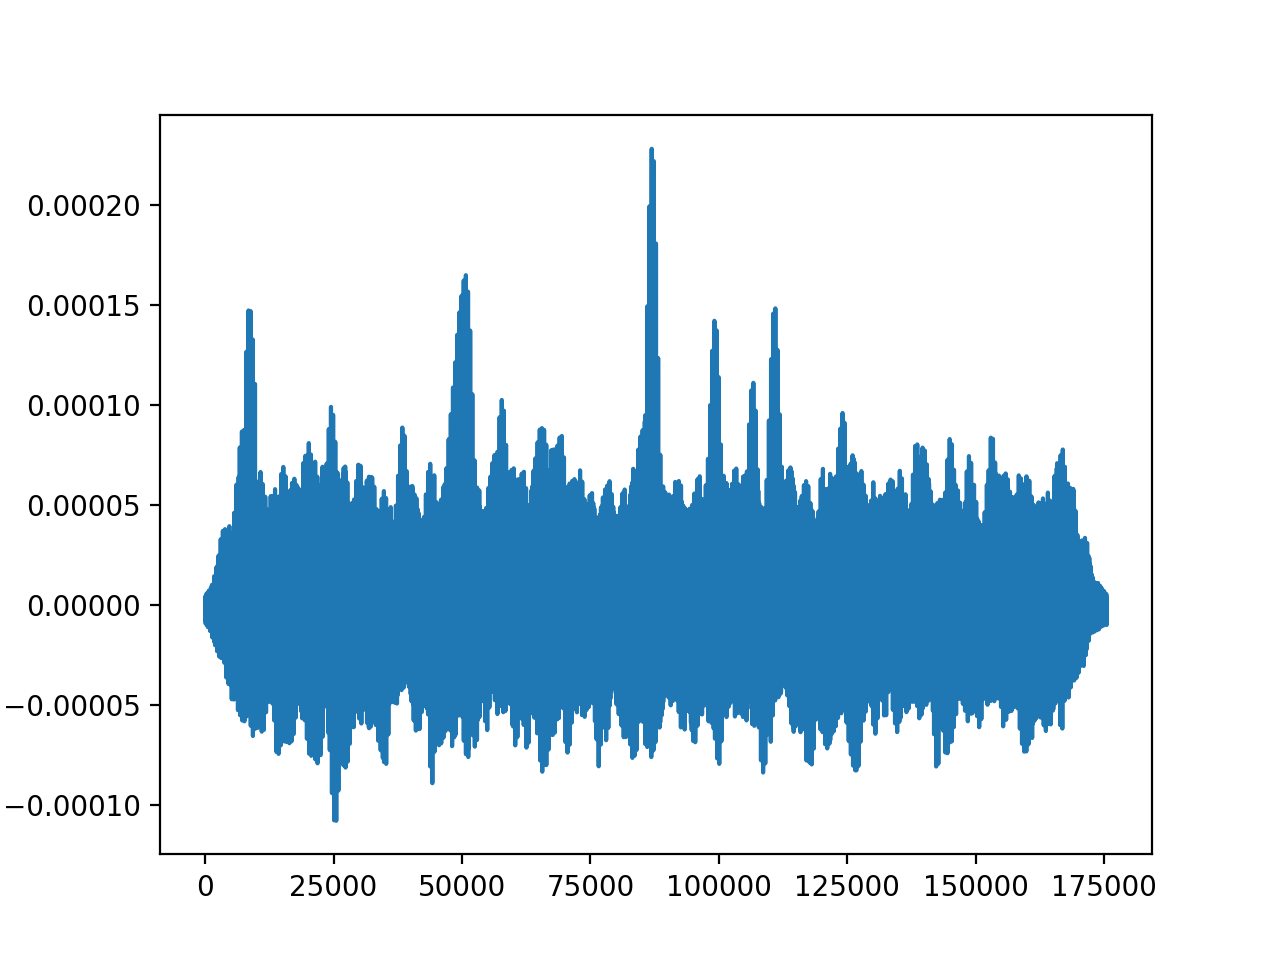

In [170]:
figure()
imshow(fdata*ext_ps_mask)

figure()
plot((fdata*ext_ps_mask).ravel())